In [1]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Exploration
In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image.

In [2]:
DATASET = "../input/EUROSAT"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Pasture', 'River', 'HerbaceousVegetation', 'Highway', 'SeaLake', 'Industrial', 'Residential', 'Forest', 'PermanentCrop']


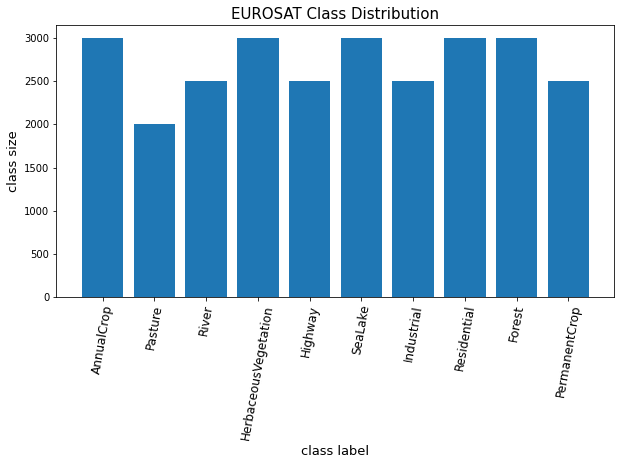

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets. 

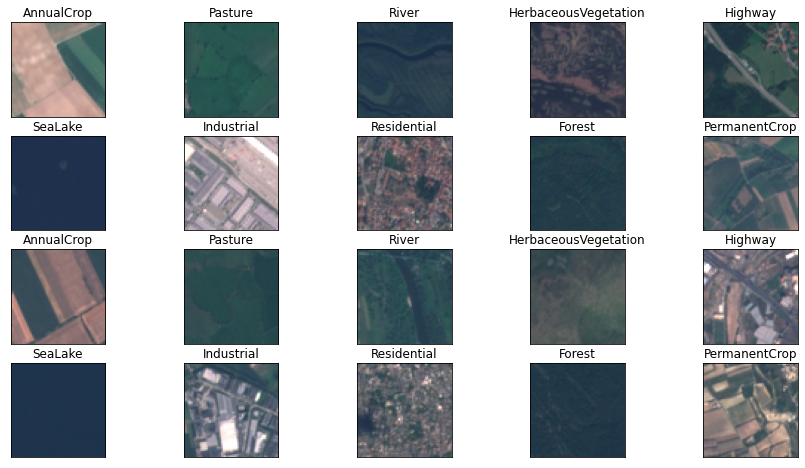

In [4]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes.

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways.

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances.

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.

In [5]:
from skimage import io

def plot_img_histogram(img_path):
    
    image = io.imread(img_path)
    plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    plt.xlabel('Intensity')
    plt.ylabel('Count')
    plt.title(img_path.split('/')[-2])
    plt.show()

We can see how the classes differ by inspecting the intensity of RGB values in each class using histograms

In [6]:
#for l in LABELS:
#    path = os.path.join(DATASET, l, l+'_1000.jpg')
#    plot_img_histogram(path)

# II. Preprocessing
I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories.

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training.

In [7]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 128
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

Using TensorFlow backend.


In [8]:
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))


split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=69)


for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    new_train_paths = [re.sub('\.\.\/input\/EUROSAT', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\.\/input\/EUROSAT', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

100%|██████████| 8100/8100 [00:15<00:00, 508.73it/s]


In [9]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.3
)


test_gen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 13235 images belonging to 10 classes.
Found 5665 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

# III. Training a Model

Transfer Learning involves the loading of a pre-trained model and using its architecture for deriving new weights off of our own data. Using the VGG16 model, which has been trained using the Imagenet dataset, I can perform a 'freeze' on it's convolutional layers and train a model on my own dataset to achieve a high performance. I'll connect the VGG16 architecture with an output layer that is appropriate for the EuroSat dataset, and train from there.

After an initial training, I'll re-compile the model with the newly-learned weights and fine-tune the model on the same training data as before. The minimum requirement I've set for myself is to achieve a Global F-Score of at least 0.80.

An F-Score is a weighted balance between a class' precision and recall during classification. An F-beta score allows you to prioritize precision or recall and indicates how well classification of a given class is performing. For this task, I've chosen an F-beta score that prioritizes Recall of information (an 'F2' score).

In [12]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adagrad


from keras.applications.vgg16 import VGG16


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [14]:
def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape,
                     pooling='avg')
    
    top_model = conv_base.output
    top_model = Dense(2048, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [15]:
optim = Adagrad()

model = compile_model(INPUT_SHAPE, NUM_CLASSES, optim, fine_tune=None)
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [16]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = valid_generator.samples//BATCH_SIZE
N_EPOCHS = 100

    # model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

In [17]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=valid_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
103/103 [==============================] - 33s 318ms/step - loss: 1.3218 - categorical_accuracy: 0.5632 - val_loss: 1.0730 - val_categorical_accuracy: 0.6541

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65412, saving model to ../working/model.weights.best.hdf5
Epoch 2/100
103/103 [==============================] - 31s 304ms/step - loss: 0.9007 - categorical_accuracy: 0.6818 - val_loss: 0.9019 - val_categorical_accuracy: 0.7110

Epoch 00002: val_categorical_accuracy improved from 0.65412 to 0.71103, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
103/103 [==============================] - 30s 291ms/step - loss: 0.8167 - categorical_accuracy: 0.7172 - val_loss: 0.7396 - val_categorical_accuracy: 0.7271

Epoch 00003: val_categorical_accuracy improved from 0.71103 to 0.72711, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
103/103 [==============================] - 30s 294ms/step - loss: 0.7651 - categorical_accuracy: 0.7346 - val

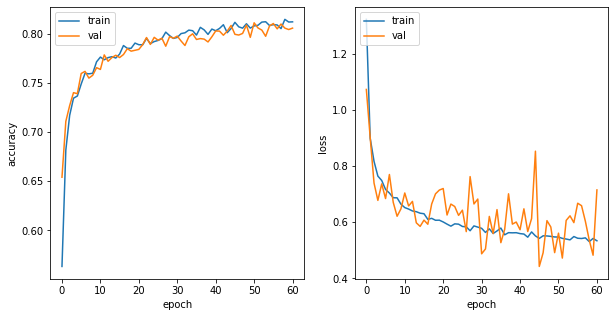

In [18]:
plot_history(history)

In [19]:
model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator.reset()

predictions = model.predict_generator(test_generator, steps=len(test_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Global F2 Score: 0.7951851851851852


,Precision,Recall,F-Score,Support
AnnualCrop,0.563961,0.921348,0.699659,890.0
Forest,0.859487,0.936313,0.896257,895.0
HerbaceousVegetation,0.878788,0.735871,0.801004,867.0
Highway,0.824111,0.570451,0.674212,731.0
Industrial,0.882749,0.888738,0.885734,737.0
Pasture,0.863985,0.701400,0.774249,643.0
PermanentCrop,0.801964,0.663957,0.726464,738.0
Residential,0.723735,0.975866,0.831099,953.0
River,0.848790,0.592124,0.697597,711.0
SeaLake,0.997446,0.835294,0.909197,935.0


## i. Fine-tuning the Model
Here I'm going to fine tune the trained model. This involves re-compiling the model - but this time I won't freeze all VGG16 convolutional layers. Here, I've decided that only the first 14 layers will be frozen from training. The last remaining layers will be trained on the dataset and hopefully, enhance the model's prediction performance on the test data. In the previous section, the model achieved a Global F2-Score of ~0.79. Fine-tuning should hopefully beat that.

In [20]:
# re-train with fine-tuning
model = compile_model(INPUT_SHAPE, NUM_CLASSES, optim, fine_tune=14)

train_generator.reset()
valid_generator.reset()

history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=valid_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
103/103 [==============================] - 33s 321ms/step - loss: 569777737.7764 - categorical_accuracy: 0.2419 - val_loss: 1.5400 - val_categorical_accuracy: 0.3883

Epoch 00001: val_categorical_accuracy did not improve from 0.81145
Epoch 2/100
103/103 [==============================] - 32s 307ms/step - loss: 1.5129 - categorical_accuracy: 0.4026 - val_loss: 1.3810 - val_categorical_accuracy: 0.4847

Epoch 00002: val_categorical_accuracy did not improve from 0.81145
Epoch 3/100
103/103 [==============================] - 32s 315ms/step - loss: 1.3184 - categorical_accuracy: 0.4936 - val_loss: 1.1823 - val_categorical_accuracy: 0.5424

Epoch 00003: val_categorical_accuracy did not improve from 0.81145
Epoch 4/100
103/103 [==============================] - 31s 305ms/step - loss: 1.2385 - categorical_accuracy: 0.5393 - val_loss: 1.1780 - val_categorical_accuracy: 0.5750

Epoch 00004: val_categorical_accuracy did not improve from 0.81145
Epoch 5/100
103/103 [===================

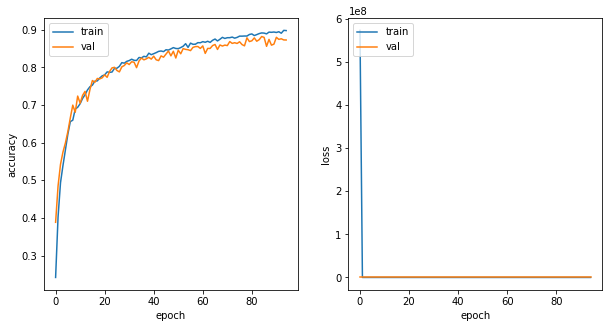

In [21]:
plot_history(history)

In [22]:
model.load_weights('../working/model.weights.best.hdf5')

test_generator.reset()

predictions = model.predict_generator(test_generator, steps=len(test_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator.classes


In [23]:
prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())

Global F2 Score: 0.8549382716049383


In [24]:
prf

,Precision,Recall,F-Score,Support
AnnualCrop,0.772867,0.844944,0.807300,890.0
Forest,0.934113,0.982123,0.957516,895.0
HerbaceousVegetation,0.781350,0.840830,0.810000,867.0
Highway,0.882105,0.573187,0.694859,731.0
Industrial,0.937792,0.818182,0.873913,737.0
Pasture,0.929577,0.821151,0.872007,643.0
PermanentCrop,0.804805,0.726287,0.763533,738.0
Residential,0.743370,1.000000,0.852796,953.0
River,0.878453,0.894515,0.886411,711.0
SeaLake,0.994413,0.951872,0.972678,935.0


In [25]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,752,5,16,14,0,15,55,0,30,3
Forest,5,879,4,0,0,5,1,0,1,0
HerbaceousVegetation,16,7,729,7,3,4,10,89,1,1
Highway,66,1,44,419,34,8,50,76,32,1
Industrial,13,0,0,2,603,0,0,119,0,0
Pasture,37,35,18,2,0,528,12,1,10,0
PermanentCrop,38,0,112,11,2,0,536,38,1,0
Residential,0,0,0,0,0,0,0,953,0,0
River,29,1,9,20,1,7,2,6,636,0
SeaLake,17,13,1,0,0,1,0,0,13,890


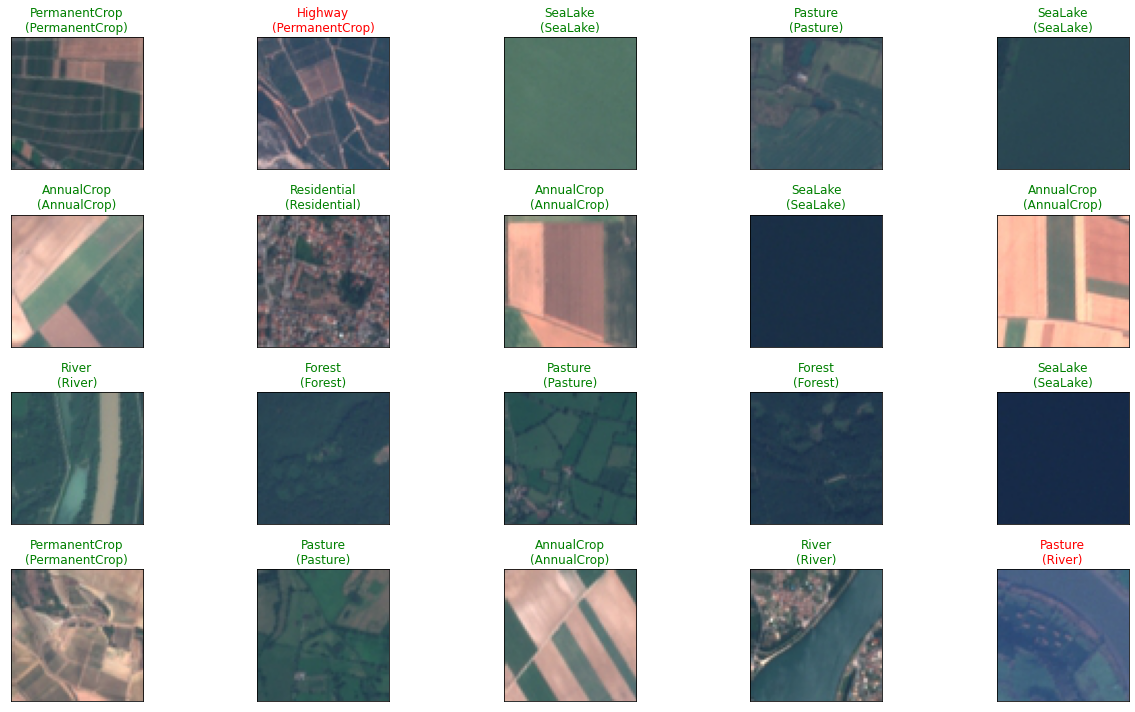

In [26]:
plot_predictions(true_classes, predictions, test_generator, class_indices)

In [27]:
# Save the model and the weights

model.save('../working/model.h5')